# Transcriptomic type assignment with centroid mapping

This notebook contains analyses to assign cell type annotations to a collection of sample data using embeddings from a reference scRNA-seq atlas dataset.
Mapping strategies are partially based on Scala et al. 2021, Nature (https://doi.org/10.1038/s41586-020-2907-3) and analyses developed by Dmitry Kobak (https://github.com/berenslab/mini-atlas)

Input files include:

###### ref_data: a sparse cell x gene counts matrix containing all reference cells to map against

###### ref_variable_genes: a dataframe containing the top n variable genes from the sample dataset

###### ref_metadata.csv: a dataframe containing, at minimum, a list of cell barcodes, their cell type annotations, and mapping coordinates

###### sample_data: a sparse cell x gene counts matrix containing all cells to map

###### sample_variable_genes: a dataframe containing the top n variable genes from the sample dataset

Output files include:

###### centroid_assignment.csv: cell type assignments for all sample cells
###### corr_scores.csv: (optional) correlation coefficients for each cell x centroid combo
###### filtered_assignments.csv: cell type assignments after thresholding on max correlation coefficient scores
###### sample_coords.csv: embeddings for all sample cells to plot onto a reference atlas
###### figs: directory with different UMAP and correlation visualizations

---

ref_variable_genes should be the list of genes that the original UMAP embeddings were derived from! 

For requirements.txt file for module versions, see https://github.com/MEUrbanek/centroid_mapping.

### Activate operating system interfacing with JupyterLab

### Load modules

In [2]:
import os
#This should point to the directory that contains your data
os.chdir('~/data/')


In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
import math
import time
import multiprocess as mp
pd.options.mode.chained_assignment = None
import scanpy as sc
import anndata as ad


In [ ]:
#Freezing requirements file to save module versions
!pip freeze > requirements.txt

### Import reference dataset

In [5]:
#Load in reference variable genes
reference_variable_genes=pd.read_table('tutorial_reference_variable_genes.csv',delimiter=',')

#Variable gene column name should be autopopulated as "x"
reference_variable_genes

,Unnamed: 0,x
0,1,ERBB4
1,2,NRXN3
2,3,CDC20B
3,4,NXPH1
4,5,HTR2C
...,...,...
2995,2996,PCBD2
2996,2997,AP3B1
2997,2998,BCKDHB
2998,2999,SLC16A1-AS1


In [6]:
#Load in reference atlas
#This should be the extracted sparse matrix from doublet_finder_matrix_extraction.rmd
#And its correspondent metadata file, which includes cell barcodes and cell type annotations
ref_data = pd.read_table('tutorial_reference_matrix.csv',delimiter=',',index_col=0)
ref_metadata= pd.read_table('tutorial_reference_metadata.csv',delimiter=',')

#Reference sparse matrix should have gene names as index, cell barcodes as column names!
ref_data

,ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1,ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1,ARKFrozen.18.PFC_AAACAGCCACTAAATC.1,ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1,ARKFrozen.18.PFC_AAACAGCCATCCATCT.1,ARKFrozen.18.PFC_AAACAGCCATGAATAG.1,ARKFrozen.18.PFC_AAACAGCCATTAGGTT.1,ARKFrozen.18.PFC_AAACATGCAATAATCC.1,ARKFrozen.18.PFC_AAACATGCACATAACT.1,ARKFrozen.18.PFC_AAACATGCATAAGGAC.1,...,ARKFrozen.8.V1_TTTGTCCCATTGCGTA.1,ARKFrozen.8.V1_TTTGTCTAGACTATTG.1,ARKFrozen.8.V1_TTTGTGAAGGACGTAA.1,ARKFrozen.8.V1_TTTGTGGCAAGCTACC.1,ARKFrozen.8.V1_TTTGTGGCACATTAAC.1,ARKFrozen.8.V1_TTTGTGGCACTCAACA.1,ARKFrozen.8.V1_TTTGTGGCAGAAACGT.1,ARKFrozen.8.V1_TTTGTGTTCATCCTAT.1,ARKFrozen.8.V1_TTTGTTGGTCCTCCAA.1,ARKFrozen.8.V1_TTTGTTGGTTTATGGG.1
AL627309.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL627309.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL669831.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01409,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM87B,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AP001591.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01148,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CYP2A13,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL121823.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Import rabies-infected datasets

In [8]:
#Load in sample_variable_genes from doublet_finder_matrix_extraction.rmd
sample_variable_genes=pd.read_table('tutorial_sample_variable_genes.csv',delimiter=',')
sample_variable_genes

,Unnamed: 0,cells_var_genes,nuc_var_genes
0,1,ISG15,FAM41C
1,2,FAAP20,HES4
2,3,ENSG00000234396,ISG15
3,4,HES5,B3GALT6
4,5,PRDM16,MRPL20
...,...,...,...
2995,2996,CMC4,TTTY1
2996,2997,MTCP1,MT-ATP6
2997,2998,LINC00278,MT-ND5
2998,2999,PCDH11Y,MT-ND6


In [9]:
#Load in sample dataset to be annotated
sample_data=pd.read_table('tutorial_sample_matrix_postdf.csv',delimiter=',',index_col=0)

#Experimental sparse matrix should have gene names as index, cell barcodes as column names!
sample_data

,u1_AAAAAAACCCGAATAA,u1_AAAAAAAGATCGACAC,u1_AAAAAAAGATTTAAGG,u1_AAAAAAAGCCAGCCTG,u1_AAAAAAATCATGAATG,u1_AAAAAAGGAATTACGC,u1_AAAAAAGTCCGTATGT,u1_AAAAAATACAATCACA,u1_AAAAAATCAAGAATCT,u1_AAAAAATTAGCCAGAT,...,u1_CCTTCATTAGGTAATG,u1_CCTTCATTATTAAGAA,u1_CCTTCCAAAGGGAGAA,u1_CCTTCCATCAGCATTG,u1_CCTTCCATCCTGACAA,u1_CCTTCCGAAATGCAAA,u1_CCTTCCGGAAAGCACA,u1_CCTTCCTAACGACCCT,u1_CCTTCCTAATACACTT,u1_CCTTCCTCCATCAATA
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000239945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000278633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000276017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000278817,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Build functions for calculating correlation coefficients and centroid-based annotation assignment

#### Correlation coefficient calculation

In [7]:
#Build corr2 (Pearson correlation coefficient) function
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

#### Map to clusters function

In [10]:
def centroid_mapping(referenceCounts, #sparse reference matrix
                             referenceGenes, #reference variable gene list
                             newCounts, #sparse sample matrix
                             newGenes, #sample variable gene list
                             referenceClusters, #reference metadata column with cell type annotations
                             normSeqDepth=True, #normalizes matrices by dividing by total counts per cell, multiplying by a scale factor, then taking the log of that value + 1 
                             scaleFactor=10000, #scale factor for normalization, scanpy and Seurat use 10,000
                             returnCmeans = False, #whether to return matrix of correlation values for each cell x centroid combo
                             totalClusters = None, #if you want to specify a different number of unique clusters
                             writeAssignmentDataframe = [], #where to save cell type assignment dataframe to on local machine
                             writeCorrScoresDataframe = []): #where to save correlation coefficient matrix on local machine

    starttime = time.time()
    print(starttime)

    if normSeqDepth:
        #Genes counts for each cell are divided by the total UMIs for that cell, then multiplied by a scale factor. 
        print('Normalizing sample matrix to sequencing depth per cell')
        newCounts.loc['total_counts'] = newCounts.sum(numeric_only=True, axis=0)
        normalized = newCounts.divide(newCounts.loc['total_counts'], axis=1)
        normalized = normalized * scaleFactor
        #This is then natural-log transformed using log1p
        X=np.log1p(normalized)
    else:
        #Or process with just the raw matrix with log1p scaling
        print('No sequencing depth normalization')
        X = np.log1p(X)
    
    #Repeat the same normalization steps as above, but for reference dataset
    if normSeqDepth:
        print('Normalizing reference matrix to sequencing depth per cell')
        referenceCounts.loc['total_counts'] = referenceCounts.sum(numeric_only=True, axis=0)
        normalized = referenceCounts.divide(referenceCounts.loc['total_counts'], axis=1)
        normalized = normalized * scaleFactor         
        T=np.log1p(normalized)
    else:
        print('No sequencing depth normalization')
        T = np.log1p(T)

    #Save the normalized copies of the matrices
    norm_ref=T.copy(deep=True)
    norm_sample=X.copy(deep=True)

    #Identify overlapping genes between reference dataset and query dataset
    gg = sorted(list(set(referenceGenes) & set(newGenes)))

    #Report back how many genes are in common+being used for query mapping
    print('Using a common set of ' + str(len(gg)) + ' genes.')
    print()
    
    #For both datasets, pull all rows corresponding to variable features
    T = T.loc[gg]
    X = X.loc[gg]

    #If clusters are already specified, set K to that number
    if totalClusters is not None:
        K = totalClusters
    #Otherwise, manually calculate the number of total clusters by adding 1 to total number of reference clusters
    else:
        types=referenceClusters.unique()
        types=pd.DataFrame(types)
        types.columns=['type_assignment']
        types['cluster_number'] = types.index
        #Make dictionary to convert to integer cluster labels
        cell_type_dict = dict(zip(types['type_assignment'],types['cluster_number']))
        numerical_clusters = referenceClusters.replace(cell_type_dict)
        K = np.max(numerical_clusters) + 1

    #Assign clusters to cells in reference atlas
    T.columns=(ref_metadata['type_updated'])
    clusters = ref_metadata['type_updated'].unique()

    #Build centroids table by calculating the mean for each variable gene for all cells within a cluster
    centroids = pd.DataFrame(index=T.index)
    for celltype in clusters:
        corresponding_cells = T[celltype]
        means=corresponding_cells.mean(axis=1)
        means=pd.DataFrame(means)
        means.columns=[celltype]
        centroids = pd.concat([centroids, means], axis=1) 

    #For each cell, calculate correlation coefficient across all variable genes for each centroid
    #print(centroids)
    input_cells=X.columns
    Cmeans=[]
    for sample_cell in input_cells:
        individual_Cmeans=[sample_cell]
        for celltype in clusters:
            calculated=corr2(X[sample_cell], centroids[celltype])
            individual_Cmeans.append(calculated)
        Cmeans.append(individual_Cmeans)
    corr_scores = pd.DataFrame(Cmeans)
    corr_scores=corr_scores.set_index(0)
    corr_scores.columns=clusters

    #Assign clusters based on highest value concordance (excluding any NaNs)
    type_assignment = corr_scores.idxmax(axis=1)

    #Save cluster assignments and correlation coefficients to local machine
    type_assignment.to_csv(writeAssignmentDataframe)
    corr_scores.to_csv(writeCorrScoresDataframe)
    
    print('Done assigning cell types! :)')
    print()
    print('This took...')
    endtime = time.time()
    print(endtime-starttime)
    print('seconds!')

    #Return normalized matrices and type assignments
    if returnCmeans:
        return type_assignment, corr_scores, norm_ref, norm_sample 
    else:
        return type_assignment, norm_ref, norm_sample


### Run map_to_clusters function of sample datasets

In [12]:
sample_cluster_assignments, sample_centroid_means, norm_ref, norm_sample = centroid_mapping(ref_data, 
                                                                                        reference_variable_genes['x'], 
                                                                                        sample_data, 
                                                                                        sample_variable_genes['cells_var_genes'], #must point to correct variable genes column!
                                                                                        ref_metadata['type'], 
                                                                                        normSeqDepth=True, 
                                                                                        returnCmeans=True, 
                                                                                        writeAssignmentDataframe='./output/tutorial_centroid_assignment.csv',
                                                                                        writeCorrScoresDataframe='./output/tutorial_corr_scores.csv')

1755229712.8553002
Normalizing sample matrix to sequencing depth per cell
Normalizing reference matrix to sequencing depth per cell
Using a common set of 1169 genes.

Done assigning cell types! :)

This took...
97.79684567451477
seconds!


### Get correlation coefficient for highest cluster per cell

In [13]:
sample_centroid_means['high_score'] = sample_centroid_means.max(axis=1)
sample_centroid_means['high_score']

print('Median of maximum correlation coefficient across cells:')
print(sample_centroid_means['high_score'].median())
print()
print('Mean of maximum correlation coefficient across cells:')
print(sample_centroid_means['high_score'].mean())
print()
print('Standard deviation of maximum correlation coefficient across cells:')
print(sample_centroid_means['high_score'].std())


Median of maximum correlation coefficient across cells:
0.42621601386818375

Mean of maximum correlation coefficient across cells:
0.42141156989324685

Standard deviation of maximum correlation coefficient across cells:
0.0952537059087738


### Plot distribution of correlation coefficients within dataset

#### Load in correlation coefficient scores if not retained after running the cells above this

In [14]:
#Reload data if needed
sample_centroid_means=pd.read_table('./output/tutorial_corr_scores.csv',delimiter=',',index_col='0')
sample_centroid_means

,EN-IT-Immature,EN-Newborn,EN-L5-ET,RG-vRG,IN-MGE-Immature,EN-Non-IT-Immature,EN-L6b,EN-L5-IT,IN-CGE-Immature,IN-NCx_dGE-Immature,...,EN-L4-IT,Astrocyte-Immature,IN-CGE-SNCG,IN-Mix-LAMP5,Vascular,Oligodendrocyte-Immature,Astrocyte-Fibrous,Cajal-Retzius cell,Oligodendrocyte,Tri-IPC
0,,,,,,,,,,,,,,,,,,,,,
u1_AAAAAAACCCGAATAA,0.298367,0.274026,0.295353,0.181567,0.199154,0.340793,0.268709,0.291647,0.204463,0.189669,...,0.306169,0.175603,0.218420,0.234317,0.178646,0.178539,0.232188,0.223747,0.271289,0.146788
u1_AAAAAAAGATCGACAC,0.045240,0.109387,0.055326,0.299168,0.104401,0.065751,0.028958,0.041387,0.089374,0.145593,...,0.085437,0.282063,0.048386,0.060635,0.174074,0.110242,0.307401,0.094915,0.193342,0.247798
u1_AAAAAAAGATTTAAGG,0.144165,0.263131,0.162076,0.338858,0.265092,0.177979,0.152822,0.135196,0.262332,0.306842,...,0.207073,0.322569,0.215425,0.194843,0.240158,0.218998,0.378664,0.251154,0.308695,0.312022
u1_AAAAAAAGCCAGCCTG,0.123312,0.233096,0.170473,0.332185,0.286502,0.164519,0.129394,0.119174,0.256609,0.328855,...,0.189139,0.281951,0.205627,0.213213,0.174170,0.196530,0.325126,0.232418,0.297999,0.254436
u1_AAAAAAATCATGAATG,0.217843,0.237241,0.253564,0.161979,0.408348,0.241007,0.188072,0.211261,0.345156,0.337079,...,0.267763,0.167067,0.329821,0.346259,0.202885,0.215891,0.252590,0.293574,0.254790,0.209163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u1_CCTTCCGAAATGCAAA,0.214623,0.231204,0.221175,0.144749,0.409998,0.217408,0.194323,0.214924,0.297435,0.286241,...,0.246157,0.148419,0.289454,0.344608,0.196150,0.184211,0.210978,0.293299,0.218032,0.186710
u1_CCTTCCGGAAAGCACA,0.076286,0.157711,0.085402,0.346473,0.099627,0.104097,0.068225,0.076242,0.087654,0.131242,...,0.121957,0.374474,0.063352,0.067853,0.189374,0.112573,0.404272,0.116696,0.288876,0.263452
u1_CCTTCCTAACGACCCT,0.467288,0.411996,0.390050,0.268664,0.275562,0.383082,0.311168,0.452054,0.304920,0.302009,...,0.466212,0.252283,0.289922,0.309101,0.257962,0.231343,0.323732,0.347814,0.369136,0.208583


In [15]:
#Format all data for violinplot() input
sample_centroid_means['high_score'] = sample_centroid_means.max(axis=1)
sample_centroid_means['high_score']

0
u1_AAAAAAACCCGAATAA    0.340793
u1_AAAAAAAGATCGACAC    0.307401
u1_AAAAAAAGATTTAAGG    0.378664
u1_AAAAAAAGCCAGCCTG    0.336361
u1_AAAAAAATCATGAATG    0.419804
                         ...   
u1_CCTTCCGAAATGCAAA    0.410220
u1_CCTTCCGGAAAGCACA    0.404272
u1_CCTTCCTAACGACCCT    0.472710
u1_CCTTCCTAATACACTT    0.471155
u1_CCTTCCTCCATCAATA    0.401694
Name: high_score, Length: 6620, dtype: float64

In [16]:
#Set violin plot parameters
from matplotlib import rcParams
rcParams['figure.figsize'] = 4, 4
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
from matplotlib import colors, colorbar

In [31]:
#Make function for plotting distributions of correlation high scores per dataset
def plot_correlation_distributions(dataset_list):
    for i in dataset_list:
        plt.ylim([0,1.1])
        plt.violinplot(i['high_score'],showmedians=True,showmeans=False,quantiles=[0.25,0.75],showextrema=False)
        plt.show()
        

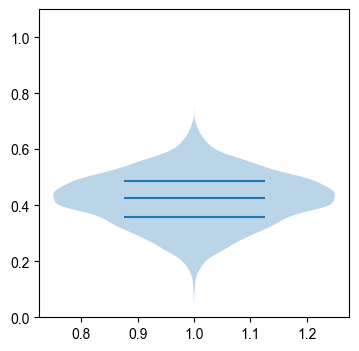

In [32]:
#Plot distribution of correlation high scores for multiple datasets
dataset_list=[sample_centroid_means]

plot_correlation_distributions(dataset_list)

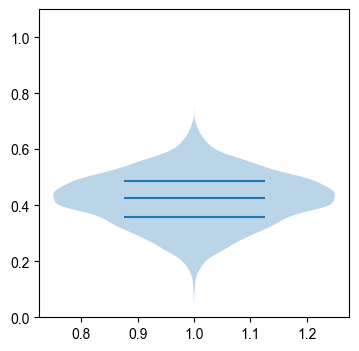

<Figure size 400x400 with 0 Axes>

In [33]:
#To save a specific figure panel (if looping through multiple datasets_
plt.ylim([0,1.1])
plt.violinplot(sample_centroid_means['high_score'],showmedians=True,showmeans=False,quantiles=[0.25,0.75],showextrema=False)
plt.show()
plt.savefig(f'./output/figs/sample_corr_dist.png', dpi=300)
        

### Threshold cell type annotations

#### Load in annotations if not retained in steps above

In [35]:
sample_cluster_assignments=pd.read_table('./output/tutorial_centroid_assignment.csv',delimiter=',')
sample_cluster_assignments.columns=['cellbarcode','celltype']
sample_cluster_assignments['datasetid']='sample'
sample_cluster_assignments

,cellbarcode,celltype,datasetid
0,u1_AAAAAAACCCGAATAA,EN-Non-IT-Immature,sample
1,u1_AAAAAAAGATCGACAC,Astrocyte-Fibrous,sample
2,u1_AAAAAAAGATTTAAGG,Astrocyte-Fibrous,sample
3,u1_AAAAAAAGCCAGCCTG,IPC-EN,sample
4,u1_AAAAAAATCATGAATG,IN-MGE-PV,sample
...,...,...,...
6615,u1_CCTTCCGAAATGCAAA,IN-MGE-PV,sample
6616,u1_CCTTCCGGAAAGCACA,Astrocyte-Fibrous,sample
6617,u1_CCTTCCTAACGACCCT,EN-L2_3-IT,sample
6618,u1_CCTTCCTAATACACTT,EN-Newborn,sample


### Threshold assignments where maximum correlation coefficient <0.2

##### This threshold should be adjusted depending on distribution of max correlation coefficients per dataset!

In [36]:
#Concatenate centroid_means dataframes for thresholding across all datasets
dataset_list=[sample_centroid_means]

centroid_means=pd.concat(dataset_list)
centroid_means

,EN-IT-Immature,EN-Newborn,EN-L5-ET,RG-vRG,IN-MGE-Immature,EN-Non-IT-Immature,EN-L6b,EN-L5-IT,IN-CGE-Immature,IN-NCx_dGE-Immature,...,Astrocyte-Immature,IN-CGE-SNCG,IN-Mix-LAMP5,Vascular,Oligodendrocyte-Immature,Astrocyte-Fibrous,Cajal-Retzius cell,Oligodendrocyte,Tri-IPC,high_score
0,,,,,,,,,,,,,,,,,,,,,
u1_AAAAAAACCCGAATAA,0.298367,0.274026,0.295353,0.181567,0.199154,0.340793,0.268709,0.291647,0.204463,0.189669,...,0.175603,0.218420,0.234317,0.178646,0.178539,0.232188,0.223747,0.271289,0.146788,0.340793
u1_AAAAAAAGATCGACAC,0.045240,0.109387,0.055326,0.299168,0.104401,0.065751,0.028958,0.041387,0.089374,0.145593,...,0.282063,0.048386,0.060635,0.174074,0.110242,0.307401,0.094915,0.193342,0.247798,0.307401
u1_AAAAAAAGATTTAAGG,0.144165,0.263131,0.162076,0.338858,0.265092,0.177979,0.152822,0.135196,0.262332,0.306842,...,0.322569,0.215425,0.194843,0.240158,0.218998,0.378664,0.251154,0.308695,0.312022,0.378664
u1_AAAAAAAGCCAGCCTG,0.123312,0.233096,0.170473,0.332185,0.286502,0.164519,0.129394,0.119174,0.256609,0.328855,...,0.281951,0.205627,0.213213,0.174170,0.196530,0.325126,0.232418,0.297999,0.254436,0.336361
u1_AAAAAAATCATGAATG,0.217843,0.237241,0.253564,0.161979,0.408348,0.241007,0.188072,0.211261,0.345156,0.337079,...,0.167067,0.329821,0.346259,0.202885,0.215891,0.252590,0.293574,0.254790,0.209163,0.419804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u1_CCTTCCGAAATGCAAA,0.214623,0.231204,0.221175,0.144749,0.409998,0.217408,0.194323,0.214924,0.297435,0.286241,...,0.148419,0.289454,0.344608,0.196150,0.184211,0.210978,0.293299,0.218032,0.186710,0.410220
u1_CCTTCCGGAAAGCACA,0.076286,0.157711,0.085402,0.346473,0.099627,0.104097,0.068225,0.076242,0.087654,0.131242,...,0.374474,0.063352,0.067853,0.189374,0.112573,0.404272,0.116696,0.288876,0.263452,0.404272
u1_CCTTCCTAACGACCCT,0.467288,0.411996,0.390050,0.268664,0.275562,0.383082,0.311168,0.452054,0.304920,0.302009,...,0.252283,0.289922,0.309101,0.257962,0.231343,0.323732,0.347814,0.369136,0.208583,0.472710


#### Apply thresholding

In [37]:
filtered_centroid_means=centroid_means[~(centroid_means['high_score'] < 0.2)] 
filtered_centroid_means

print('Number of cells pre-thresholding:')
print(len(centroid_means))
print()
print('Number of cells post-thesholding:')
print(len(filtered_centroid_means))
print()
print('Percentage of cells retrained for analysis:')
print((len(filtered_centroid_means)/len(centroid_means)*100))

Number of cells pre-thresholding:
6620

Number of cells post-thesholding:
6543

Percentage of cells retrained for analysis:
98.83685800604229


### Concatenate thresholded annotations into dataframe w/ dataset ID

In [38]:
sample_filtered_assignment = sample_cluster_assignments[sample_cluster_assignments['cellbarcode'].isin(filtered_centroid_means.index)]

filtered_assignments = pd.concat([sample_filtered_assignment], 
                                 axis=0, 
                                 ignore_index=True)

filtered_assignments

,cellbarcode,celltype,datasetid
0,u1_AAAAAAACCCGAATAA,EN-Non-IT-Immature,sample
1,u1_AAAAAAAGATCGACAC,Astrocyte-Fibrous,sample
2,u1_AAAAAAAGATTTAAGG,Astrocyte-Fibrous,sample
3,u1_AAAAAAAGCCAGCCTG,IPC-EN,sample
4,u1_AAAAAAATCATGAATG,IN-MGE-PV,sample
...,...,...,...
6538,u1_CCTTCCGAAATGCAAA,IN-MGE-PV,sample
6539,u1_CCTTCCGGAAAGCACA,Astrocyte-Fibrous,sample
6540,u1_CCTTCCTAACGACCCT,EN-L2_3-IT,sample
6541,u1_CCTTCCTAATACACTT,EN-Newborn,sample


#### Export thresholded cell annotations

In [40]:
filtered_assignments.to_csv('./output/tutorial_filtered_assignments.csv')

## Visualization

### Build function for mapping sample cells to reference UMAP coordinates

In [41]:
def coordinate_mapping(normRef, #normalized reference matrix generated from centroid_mapping()
                       referenceGenes, #variable genes for reference dataset
                       normSample, #normalized sample matrix generated from centroid_mapping()
                       newGenes, #variable genes for sample dataset
                       referenceAtlas, #dataframe with UMAP coords for each cell from reference dataset
                       selectMedian=True, #derives coordinates from median, for weighted means set to False
                       knn = 10, #k nearest neighbors to use for extracting coordinates
                       workers = 1, #number of workers to call for multiprocessing
                       write_assignment_dataframe = []): #where to save sample coordinates to local machine
    
    if __name__ == '__main__':    
    
        starttime = time.time()
        print(starttime)

    #Identify overlapping genes between reference dataset and query dataset
        gg = sorted(list(set(referenceGenes) & set(newGenes)))

    #Report back how many genes are in common+being used for query mapping
        print('Using a common set of ' + str(len(gg)) + ' genes.')
        print()
    
    #For query dataset, pull all rows corresponding to variable features
        T = normRef.loc[gg]
        X = normSample.loc[gg]

        #Calculate correlation coefficients for each cell in reference dataset x each cell in sample dataset
        ref_population=T.columns
        input_cells=X.columns
        assignmentPositions=pd.DataFrame()
        individual_assignment=[]
        print('Beginning correlation calculations')

        #Will assign coordinates based on median of independent (x,y) coordinates from k nearest neighbors
        if selectMedian == True:
            print('Assigning coordinates based on median')

        #Will assign coordinates based on correlation coefficient-weighted, independent (x,y) coordinates from k nearest neighbors
        if selectMedian==False:
            print('Assigning coordinates based on weighted means')
            
        global build_correlations
    
        def build_correlations(sample_cell):
            global build_correlations
            print('.', end='', flush=True)
            individual_corr=[]
            #Calculate correlation coefficients for all cells
            for ref_cell in ref_population:
                calculated=corr2(X[sample_cell], T[ref_cell])
                individual_corr.append(calculated)
            #Take the top k nearest neighbors
            ind = referenceAtlas[np.argpartition(individual_corr, -knn)][-knn:]

            #Pull median coordinates from nearest neighbors
            if selectMedian == True:
                individual_assignment = np.median(ind,axis=0)

            #Calculated weighted coordinates from nearest neighbors
            if selectMedian == False:
                res = np.array(individual_corr)
                weights= res[np.argpartition(res, -knn)][-knn:]
                weights=np.transpose(weights)
                individual_assignment = np.average(ind,axis=0,weights=weights)

            #Concatenate each pair of coordinates for a sample cell together
            temp = pd.DataFrame(individual_assignment)
            temp.columns=[sample_cell]
            return temp

        #Call workers for multiprocessing
        print('Calling workers')
        pool = mp.Pool(workers)

        #Execute build_correlations via multiprocessing
        assignmentPositions=pd.concat(pool.map(build_correlations, input_cells), axis=1)

        #Save coordinates for all sample cells to local machine
        print(assignmentPositions)
        assignmentPositions=assignmentPositions.T
        assignmentPositions.to_csv(write_assignment_dataframe)

        print('Done finding UMAP coords! :)')
        print()
        print('This took...')
        endtime = time.time()
        print(endtime-starttime)
        print('seconds!')
        
        return assignmentPositions

In [42]:
#Pull UMAP coordinates for reference atlas
ref_coords = ref_metadata[['umap_1','umap_2']].to_numpy()
ref_coords

array([[-6.31361536, -0.63399025],
       [-1.47846452, -2.07969245],
       [-7.98787311, -5.01011213],
       ...,
       [ 2.55811378,  1.58081487],
       [-8.2492843 , -0.74578234],
       [-8.57090429, -0.45176986]])

In [ ]:
sample_pos = coordinate_mapping(norm_ref,
                                reference_variable_genes['x'],
                                norm_sample, 
                                sample_variable_genes['cells_var_genes'],
                                ref_coords, 
                                knn=10, 
                                workers=4,
                                selectMedian=True, 
                                write_assignment_dataframe='./output/tutorial_sample_coords.csv')

### AnnData formatting with scanpy

In [46]:
#If needed, reload coordinate dataframes generated in the steps above
sample_coords=pd.read_table('./output/tutorial_sample_coords.csv',delimiter=',') 
sample_coords

,Unnamed: 0,0,1
0,u1_AAAAAAACCCGAATAA,-7.375658,-4.513052
1,u1_AAAAAAAGATCGACAC,8.006872,5.713114
2,u1_AAAAAAAGATTTAAGG,9.164844,4.632798
3,u1_AAAAAAAGCCAGCCTG,5.596750,-4.692593
4,u1_AAAAAAATCATGAATG,1.841050,-9.946890
...,...,...,...
6615,u1_CCTTCCGAAATGCAAA,1.914843,-10.267541
6616,u1_CCTTCCGGAAAGCACA,9.609870,3.419312
6617,u1_CCTTCCTAACGACCCT,-5.832988,0.096015
6618,u1_CCTTCCTAATACACTT,-2.013341,-2.231209


In [47]:
#If running multiple datasets, concatenate them
coords_df=pd.concat([sample_coords], ignore_index=True, axis=0)

In [48]:
#Clean up column names
coords_df.columns=['cellbarcode','umap_1','umap_2']
coords_df

,cellbarcode,umap_1,umap_2
0,u1_AAAAAAACCCGAATAA,-7.375658,-4.513052
1,u1_AAAAAAAGATCGACAC,8.006872,5.713114
2,u1_AAAAAAAGATTTAAGG,9.164844,4.632798
3,u1_AAAAAAAGCCAGCCTG,5.596750,-4.692593
4,u1_AAAAAAATCATGAATG,1.841050,-9.946890
...,...,...,...
6615,u1_CCTTCCGAAATGCAAA,1.914843,-10.267541
6616,u1_CCTTCCGGAAAGCACA,9.609870,3.419312
6617,u1_CCTTCCTAACGACCCT,-5.832988,0.096015
6618,u1_CCTTCCTAATACACTT,-2.013341,-2.231209


In [77]:
#Link sample cell coordinates to their assigned cell types from the centroid mapping steps above
filtered_assignments=pd.read_table('./output/tutorial_filtered_assignments.csv',delimiter=',')
annotated_coords=pd.merge(filtered_assignments, coords_df, how='inner', on='cellbarcode')
annotated_coords

,Unnamed: 0,cellbarcode,celltype,datasetid,umap_1,umap_2
0,0,u1_AAAAAAACCCGAATAA,EN-Non-IT-Immature,sample,-7.375658,-4.513052
1,1,u1_AAAAAAAGATCGACAC,Astrocyte-Fibrous,sample,8.006872,5.713114
2,2,u1_AAAAAAAGATTTAAGG,Astrocyte-Fibrous,sample,9.164844,4.632798
3,3,u1_AAAAAAAGCCAGCCTG,IPC-EN,sample,5.596750,-4.692593
4,4,u1_AAAAAAATCATGAATG,IN-MGE-PV,sample,1.841050,-9.946890
...,...,...,...,...,...,...
6538,6538,u1_CCTTCCGAAATGCAAA,IN-MGE-PV,sample,1.914843,-10.267541
6539,6539,u1_CCTTCCGGAAAGCACA,Astrocyte-Fibrous,sample,9.609870,3.419312
6540,6540,u1_CCTTCCTAACGACCCT,EN-L2_3-IT,sample,-5.832988,0.096015
6541,6541,u1_CCTTCCTAATACACTT,EN-Newborn,sample,-2.013341,-2.231209


#### Some examples for adding more metadata to annotated_coords dataframe (very hard-coded, will differ significantly by dataset!)

In [ ]:
###WILL DIFFER BY DATASET, BUT FOR REFERENCE WHEN ADDING MORE METADATA TO CELLS
##Add more metadata to sample_coords
#clusters=annotated_coords['celltype'].unique()

##Define broad classes
#en=['EN-L5_6-NP', 'EN-L4-IT','EN-Newborn', 'EN-L2_3-IT','EN-L6b','EN-IT-Immature','EN-L5-ET',
#    'EN-L6-CT', 'EN-L6-IT','EN-Non-IT-Immature','EN-L5-IT','Cajal-Retzius cell']
#inh=['IN-NCx_dGE-Immature','IN-CGE-Immature','IN-MGE-SST','IN-CGE-VIP', 'IN-CGE-SNCG',
#     'IN-MGE-PV','IN-Mix-LAMP5','IN-MGE-Immature']
#pro=['IPC-EN','Tri-IPC']
#glia=['Astrocyte-Fibrous','Microglia','OPC','Vascular','Astrocyte-Protoplasmic','RG-vRG',
#      'Oligodendrocyte','Oligodendrocyte-Immature','Astrocyte-Immature','RG-tRG','RG-oRG']
#unknown=['Unknown']
#annotated_coords['broad_class']=sample_coords['celltype'].copy()
#annotated_coords.loc[sample_coords['celltype'].isin(en), 'broad_class'] = 'EN'
#annotated_coords.loc[sample_coords['celltype'].isin(inh), 'broad_class'] = 'IN'
#annotated_coords.loc[sample_coords['celltype'].isin(pro), 'broad_class'] = 'IPC'
#annotated_coords.loc[sample_coords['celltype'].isin(glia), 'broad_class'] = 'Glia'
#annotated_coords.loc[sample_coords['celltype'].isin(unknown), 'broad_class'] = 'Unknown'

##Define subclasses (layer identies for excitatory neurons, types for glia, region for inhibitory)
#astro=['Astrocyte-Fibrous','Astrocyte-Protoplasmic','Astrocyte-Immature']
#opc=['OPC','Oligodendrocyte','Oligodendrocyte-Immature']
#rgc=['RG-tRG','RG-oRG','RG-vRG']

#mge=['IN-MGE-SST','IN-MGE-PV','IN-MGE-Immature']
#cge=['IN-CGE-Immature','IN-CGE-VIP', 'IN-CGE-SNCG']
#dge=['IN-NCx_dGE-Immature']

#immature=['EN-Newborn','EN-IT-Immature','EN-Non-IT-Immature']
#deep=['EN-L5_6-NP','EN-L6b','EN-L5-ET','EN-L6-CT', 'EN-L6-IT','EN-L5-IT']

#annotated_coords['subclass']=annotated_coords['celltype'].copy()
#annotated_coords.loc[annotated_coords['celltype'].isin(astro), 'subclass'] = 'Astrocyte'
#annotated_coords.loc[annotated_coords['celltype'].isin(opc), 'subclass'] = 'Oligo'
#annotated_coords.loc[annotated_coords['celltype'].isin(rgc), 'subclass'] = 'RG'
#annotated_coords.loc[annotated_coords['celltype'].isin(pro), 'subclass'] = 'IPC'
#annotated_coords.loc[annotated_coords['celltype'].isin(mge), 'subclass'] = 'IN-MGE'
#annotated_coords.loc[annotated_coords['celltype'].isin(cge), 'subclass'] = 'IN-CGE'
#annotated_coords.loc[annotated_coords['celltype'].isin(dge), 'subclass'] = 'IN-DGE'
#annotated_coords.loc[annotated_coords['celltype'].isin(immature), 'subclass'] = 'EN-Immature'
#annotated_coords.loc[annotated_coords['celltype'].isin(deep), 'subclass'] = 'EN-Deep Layer'

#sample_coords['subclass'].unique()

In [78]:
#Add reference metadata columns to annotated_coords dataframe
subset_ref_metadata=ref_metadata[['Unnamed: 0','type','dataset','umap_1','umap_2']]
subset_ref_metadata['dataset']='ref'
subset_ref_metadata.columns=['cellbarcode','celltype','datasetid','umap_1','umap_2']

annotated_coords=annotated_coords[['cellbarcode','celltype','datasetid','umap_1','umap_2']]

annotated_coords=pd.concat([annotated_coords,subset_ref_metadata],ignore_index=True)
annotated_coords

,cellbarcode,celltype,datasetid,umap_1,umap_2
0,u1_AAAAAAACCCGAATAA,EN-Non-IT-Immature,sample,-7.375658,-4.513052
1,u1_AAAAAAAGATCGACAC,Astrocyte-Fibrous,sample,8.006872,5.713114
2,u1_AAAAAAAGATTTAAGG,Astrocyte-Fibrous,sample,9.164844,4.632798
3,u1_AAAAAAAGCCAGCCTG,IPC-EN,sample,5.596750,-4.692593
4,u1_AAAAAAATCATGAATG,IN-MGE-PV,sample,1.841050,-9.946890
...,...,...,...,...,...
76077,ARKFrozen-8-V1_TTTGTGGCACTCAACA-1,EN-L6-IT,ref,-9.293418,-1.675112
76078,ARKFrozen-8-V1_TTTGTGGCAGAAACGT-1,EN-Non-IT-Immature,ref,-5.734272,-5.964089
76079,ARKFrozen-8-V1_TTTGTGTTCATCCTAT-1,EN-Newborn,ref,2.558114,1.580815
76080,ARKFrozen-8-V1_TTTGTTGGTCCTCCAA-1,EN-IT-Immature,ref,-8.249284,-0.745782


In [87]:
#This may not be needed for your dataset!
#Fix autoformatting that happens when concatenating sparse matrices together
annotated_coords['cellbarcode'] = annotated_coords['cellbarcode'].str.replace('-','.')

In [84]:
#Pool normalized matrices from different datasets together
normalized_matrices=pd.concat([norm_sample,norm_ref],axis=1)
normalized_matrices

,u1_AAAAAAACCCGAATAA,u1_AAAAAAAGATCGACAC,u1_AAAAAAAGATTTAAGG,u1_AAAAAAAGCCAGCCTG,u1_AAAAAAATCATGAATG,u1_AAAAAAGGAATTACGC,u1_AAAAAAGTCCGTATGT,u1_AAAAAATACAATCACA,u1_AAAAAATCAAGAATCT,u1_AAAAAATTAGCCAGAT,...,ARKFrozen.8.V1_TTTGTCCCATTGCGTA.1,ARKFrozen.8.V1_TTTGTCTAGACTATTG.1,ARKFrozen.8.V1_TTTGTGAAGGACGTAA.1,ARKFrozen.8.V1_TTTGTGGCAAGCTACC.1,ARKFrozen.8.V1_TTTGTGGCACATTAAC.1,ARKFrozen.8.V1_TTTGTGGCACTCAACA.1,ARKFrozen.8.V1_TTTGTGGCAGAAACGT.1,ARKFrozen.8.V1_TTTGTGTTCATCCTAT.1,ARKFrozen.8.V1_TTTGTTGGTCCTCCAA.1,ARKFrozen.8.V1_TTTGTTGGTTTATGGG.1
MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000239945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC022695.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL391987.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL355870.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AP001591.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
#Getting list of cells to include in AnnData file
index_list = annotated_coords['cellbarcode']
index_list

0                      u1_AAAAAAACCCGAATAA
1                      u1_AAAAAAAGATCGACAC
2                      u1_AAAAAAAGATTTAAGG
3                      u1_AAAAAAAGCCAGCCTG
4                      u1_AAAAAAATCATGAATG
                       ...                
76077    ARKFrozen.8.V1_TTTGTGGCACTCAACA.1
76078    ARKFrozen.8.V1_TTTGTGGCAGAAACGT.1
76079    ARKFrozen.8.V1_TTTGTGTTCATCCTAT.1
76080    ARKFrozen.8.V1_TTTGTTGGTCCTCCAA.1
76081    ARKFrozen.8.V1_TTTGTTGGTTTATGGG.1
Name: cellbarcode, Length: 76082, dtype: object

In [89]:
#Subset normalized_matrices down to cells passing all thresholds
all_matrices=normalized_matrices[index_list]
all_matrices=all_matrices.transpose()
all_matrices

,MIR1302-2HG,FAM138A,OR4F5,ENSG00000238009,ENSG00000239945,ENSG00000239906,ENSG00000241860,ENSG00000241599,ENSG00000286448,ENSG00000236601,...,AP000547.4,AC007879.5,AC090505.2,AC008453.1,AC003985.1,AC022695.3,AL391987.2,AL355870.1,AP001591.1,AL121823.1
u1_AAAAAAACCCGAATAA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1_AAAAAAAGATCGACAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1_AAAAAAAGATTTAAGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1_AAAAAAAGCCAGCCTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u1_AAAAAAATCATGAATG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARKFrozen.8.V1_TTTGTGGCACTCAACA.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARKFrozen.8.V1_TTTGTGGCAGAAACGT.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARKFrozen.8.V1_TTTGTGTTCATCCTAT.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARKFrozen.8.V1_TTTGTTGGTCCTCCAA.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
#Make scanpy AnnData object
adata = sc.AnnData(all_matrices)
adata

AnnData object with n_obs × n_vars = 76082 × 48603

In [91]:
#Add metadata from annotated_coords table to AnnData object
annotated_coords=annotated_coords.set_index('cellbarcode')
adata.obs=pd.concat([adata.obs, annotated_coords], axis=1)
adata.obs

,celltype,datasetid,umap_1,umap_2
u1_AAAAAAACCCGAATAA,EN-Non-IT-Immature,sample,-7.375658,-4.513052
u1_AAAAAAAGATCGACAC,Astrocyte-Fibrous,sample,8.006872,5.713114
u1_AAAAAAAGATTTAAGG,Astrocyte-Fibrous,sample,9.164844,4.632798
u1_AAAAAAAGCCAGCCTG,IPC-EN,sample,5.596750,-4.692593
u1_AAAAAAATCATGAATG,IN-MGE-PV,sample,1.841050,-9.946890
...,...,...,...,...
ARKFrozen.8.V1_TTTGTGGCACTCAACA.1,EN-L6-IT,ref,-9.293418,-1.675112
ARKFrozen.8.V1_TTTGTGGCAGAAACGT.1,EN-Non-IT-Immature,ref,-5.734272,-5.964089
ARKFrozen.8.V1_TTTGTGTTCATCCTAT.1,EN-Newborn,ref,2.558114,1.580815
ARKFrozen.8.V1_TTTGTTGGTCCTCCAA.1,EN-IT-Immature,ref,-8.249284,-0.745782


##### If you want to add additional metadata at any point, AnnData.obs behaves like a pandas dataframe

In [92]:
#Add centroid correlation high scores for scaling dot size based on mapping confidence
#This will leave ref cells blank!
adata.obs=pd.concat([adata.obs, filtered_centroid_means['high_score']],axis=1)
adata.obs

,celltype,datasetid,umap_1,umap_2,high_score
u1_AAAAAAACCCGAATAA,EN-Non-IT-Immature,sample,-7.375658,-4.513052,0.340793
u1_AAAAAAAGATCGACAC,Astrocyte-Fibrous,sample,8.006872,5.713114,0.307401
u1_AAAAAAAGATTTAAGG,Astrocyte-Fibrous,sample,9.164844,4.632798,0.378664
u1_AAAAAAAGCCAGCCTG,IPC-EN,sample,5.596750,-4.692593,0.336361
u1_AAAAAAATCATGAATG,IN-MGE-PV,sample,1.841050,-9.946890,0.419804
...,...,...,...,...,...
ARKFrozen.8.V1_TTTGTGGCACTCAACA.1,EN-L6-IT,ref,-9.293418,-1.675112,NaN
ARKFrozen.8.V1_TTTGTGGCAGAAACGT.1,EN-Non-IT-Immature,ref,-5.734272,-5.964089,NaN
ARKFrozen.8.V1_TTTGTGTTCATCCTAT.1,EN-Newborn,ref,2.558114,1.580815,NaN
ARKFrozen.8.V1_TTTGTTGGTCCTCCAA.1,EN-IT-Immature,ref,-8.249284,-0.745782,NaN


In [95]:
#Send embeddings to .obsm 
coords=adata.obs[['umap_1', 'umap_2']].to_numpy()
adata.obsm['umap'] = coords

### UMAP Visualizations

In [100]:
#Set figure export location
#For more settings, see https://scanpy.readthedocs.io/en/latest/generated/scanpy.settings.html#scanpy.settings
sc.settings.figdir = './output/figs/'

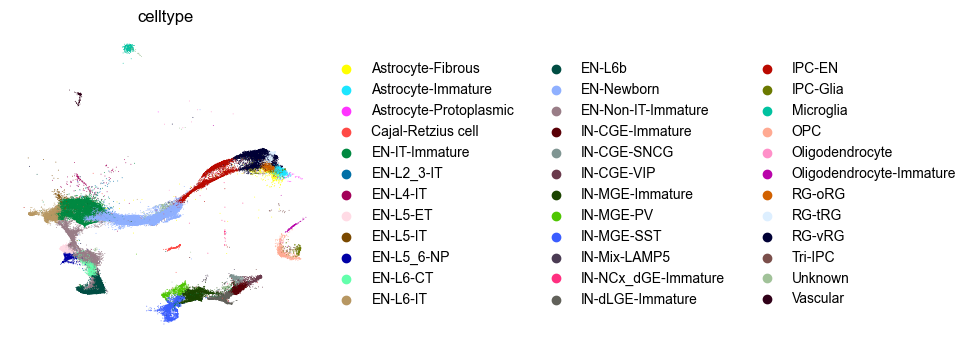

In [103]:
#Plot all clusters w/ cells sized by max correlation value
sc.pl.umap(adata, 
           color='celltype',
           #size=adata.obs['high_score'],
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           frameon=False,
           save='_annotated_umap.png'
          )

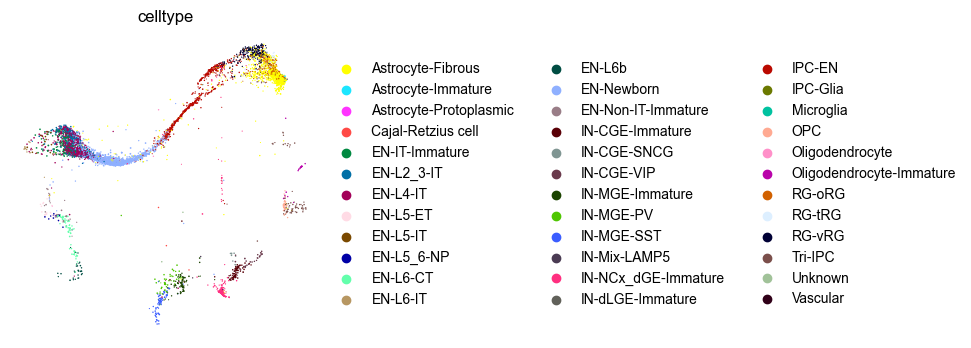

In [113]:
#Plot all clusters w/ samples cells sized by max correlation value, no reference cells
sc.pl.umap(adata, 
           color='celltype',
           size=adata.obs['high_score']*10, # *N lets you scale so differences between dotws are more obvious
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           frameon=False,
           save='_annotated_umap_scaled.png'
          )

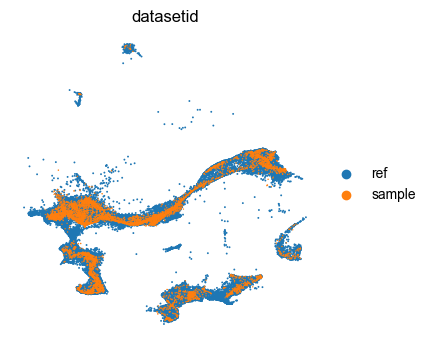

In [140]:
#Plot all clusters w/ samples cells sized by max correlation value, no reference cells

#Add max correlation coefficients to scale reference dots
refscaled_adata=adata.copy()
refscaled_adata.obs['high_score'].fillna(value=refscaled_adata_obs['high_score'].max(),inplace=True)

#Reverse order to plot sample data on top
refscaled_adata.obs = refscaled_adata.obs.iloc[::-1]

sc.pl.umap(refscaled_adata, 
           color='datasetid',
           size=refscaled_adata.obs['high_score']*10, # *N lets you scale so differences between dotws are more obvious
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           frameon=False,
           save='_by_dataset.png'
          )

In [120]:
#Make function for plotting feature plots

def plot_features(data, #adata object w/ normalized matrices
                  features, #list of features to be plotted
                 scaling=False #sets whether to scale cell size by maximum correlation coefficient
                 ): 
    if scaling:
        for i in features:
            sc.pl.umap(data, 
                       color=i, 
                       color_map='magma',
                       #vmin=4, #sets lower color limit (enables color scaling)
                       #vmax=8, #sets upper color limit (enables color scaling)
                       legend_fontsize=7,
                       legend_fontoutline=2,
                       legend_loc='on data',
                       ncols=4,
                       size=data.obs['high_score']*20,
                       frameon=False, 
                       save=(f'{i}.png')
                      )
    
    else:
        for i in features:
            sc.pl.umap(data, 
                       color=i, 
                       color_map='magma',
                       #vmin=4, #sets lower color limit (enables color scaling)
                       #vmax=8, #sets upper color limit (enables color scaling)
                       legend_fontsize=7,
                       legend_fontoutline=2,
                       legend_loc='on data',
                       ncols=4,
                       size=40,
                       frameon=False, 
                       save=(f'{i}.png')
                      )
        

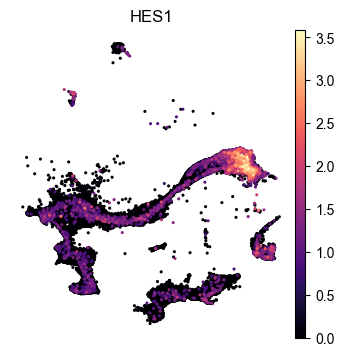

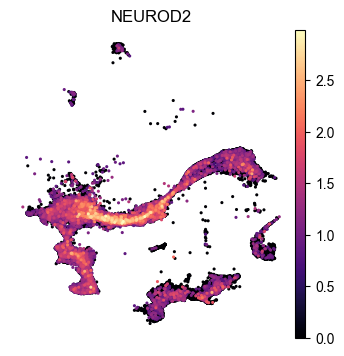

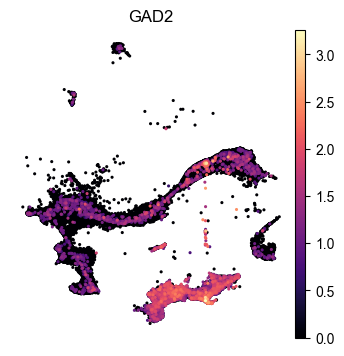

In [116]:
#Plot feature plots for all data together
features=['HES1','NEUROD2','GAD2']

plot_features(adata, features)

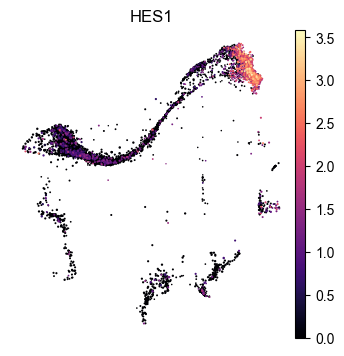

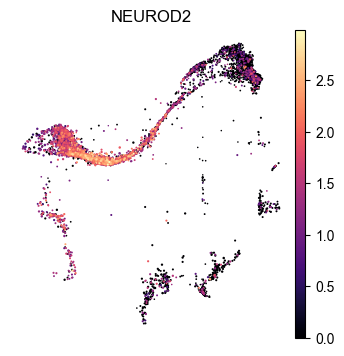

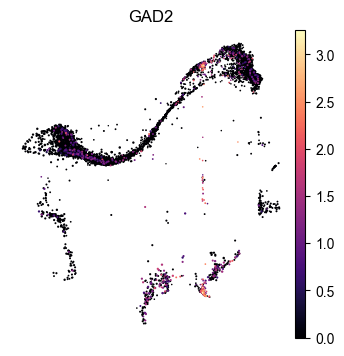

In [121]:
#Plot feature plots just for sample data
features=['HES1','NEUROD2','GAD2']
plot_features(sample_adata, features, scaling=True)